In [1]:
import pandas as pd
import numpy as np
import re
import nltk
import seaborn as sns
import string
import matplotlib.pyplot as plt

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.naive_bayes import MultinomialNB, GaussianNB
from sklearn.model_selection import GridSearchCV, cross_val_score, train_test_split
from sklearn.metrics import accuracy_score, classification_report

from nltk.stem import PorterStemmer, WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

from imblearn.over_sampling import RandomOverSampler

#nltk.download('wordnet')

### Load The Data

We have the data already split into training, testing, and validation sets. But the train.csv isn't labeled. So we load and merge train.csv and val.csv, and since the data is sufficiently large, we then split it into training, testing, and validation sets.

In [2]:
# Load 
train_data = pd.read_csv("train.csv")
val_data = pd.read_csv("val.csv")

In [3]:
# Merge train_data and val_data
merged_data = pd.concat([train_data, val_data], ignore_index=True)

# Save the merged data to a new CSV file
merged_data.to_csv("merged_data.csv", index=False)

In [4]:
# Split data into train, validation, and test sets
train_data, temp_data = train_test_split(merged_data, test_size=0.25, random_state=42)
remaining_data = temp_data.copy()

val_data, test_data = train_test_split(remaining_data, test_size=0.4, random_state=42)

### Explore The Data

In [6]:
merged_data.head()

,text,label
0,The court granted by a 5-4 vote a request made...,real
1,""" Pennsylvania was a crucial swing state in th...",real
2,The company today is rolling out an update to ...,fake
3,"When it comes to trade policy, Hillary Clinton...",real
4,S. stocks had their worst April start since 19...,real


In [7]:
# Number of rows
num_rows = len(train_data)

# Number of fake news
num_fake_news = train_data[train_data['label'] == 'fake'].shape[0]

# Number of real news
num_real_news = train_data[train_data['label'] == 'real'].shape[0]

# Print summary
print("Training Data Summary")
print("____________________________")
print("Number of rows:", num_rows)
print("Number of fake news:", num_fake_news)
print("Number of real news:", num_real_news)

Training Data Summary
____________________________
Number of rows: 203001
Number of fake news: 58796
Number of real news: 144205


In [8]:
# Number of rows
num_rows = len(val_data)

# Number of fake news
num_fake_news = val_data[val_data['label'] == 'fake'].shape[0]

# Number of real news
num_real_news = val_data[val_data['label'] == 'real'].shape[0]

# Print summary
print("Validation Data Summary")
print("___________________________")
print("Number of rows:", num_rows)
print("Number of fake news:", num_fake_news)
print("Number of real news:", num_real_news)

Validation Data Summary
___________________________
Number of rows: 40600
Number of fake news: 11817
Number of real news: 28783


In [9]:
# Number of rows
num_rows = len(test_data)

# Number of fake news
num_fake_news = test_data[test_data['label'] == 'fake'].shape[0]

# Number of real news
num_real_news = test_data[test_data['label'] == 'real'].shape[0]

# Print summary
print("Testing Data Summary")
print("___________________________")
print("Number of rows:", num_rows)
print("Number of fake news:", num_fake_news)
print("Number of real news:", num_real_news)

Testing Data Summary
___________________________
Number of rows: 27068
Number of fake news: 7847
Number of real news: 19221


In [10]:
# Number of rows
num_rows = len(merged_data)

# Number of fake news
num_fake_news = merged_data[merged_data['label'] == 'fake'].shape[0]

# Number of real news
num_real_news = merged_data[merged_data['label'] == 'real'].shape[0]

# Print summary
print("Entire Data Summary")
print("___________________________")
print("Number of rows:", num_rows)
print("Number of fake news:", num_fake_news)
print("Number of real news:", num_real_news)

Entire Data Summary
___________________________
Number of rows: 270669
Number of fake news: 78460
Number of real news: 192209


### Initializations for Data Preparation

In [11]:
svd = TruncatedSVD(n_components=85) # for dim reduction
tfidf_vectorizer = TfidfVectorizer(min_df = 3, max_df=0.9, ngram_range=(1,2)) # use tf-idf representation of words to make them numeric and count
count_vectorizer = CountVectorizer(min_df=3, max_df=0.9, ngram_range=(1, 2)) # represent words numericly and count
oversampler = RandomOverSampler() # for handling class imbalance

In [12]:
def preprocess_text(text):
    """
    Preprocesses the input text by expanding contractions, removing URLs, tokenizing,
    lowercasing, removing punctuation, numbers, and special characters, lemmatizing,
    stemming, and handling HTML tags or markup.

    Args:
    text (str): Input text to be preprocessed.

    Returns:
    str: Preprocessed text.
    """
    
    # Expand contractions
    text = re.sub(r"can't", "cannot", text)
    text = re.sub(r"won't", "will not", text)
    text = re.sub(r"don't", "do not", text)
    text = re.sub(r"haven't", "have not", text)
    text = re.sub(r"aren't", "are not", text)
    text = re.sub(r"isn't", "is not", text)
    text = re.sub(r"wasn't", "was not", text)
    text = re.sub(r"weren't", "were not", text)
    text = re.sub(r"shan't", "shall not", text)

    # Remove URLs
    text = re.sub(r'https?://\S+|www\.\S+', '', text)

    # Tokenization
    tokens = word_tokenize(text)
    
    # Lowercasing
    tokens = [token.lower() for token in tokens]
    
    # Removing Punctuation, Numbers, and Special Characters
    tokens = [re.sub(r'[^a-zA-Z]', '', token) for token in tokens]
    
    # Removing Stopwords. We comment this out since it reduced our accuracy
    #stop_words = set(stopwords.words('english'))
    #tokens = [token for token in tokens if token not in stop_words]
    
    # Lemmatization (inital form of the wor)
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(token) for token in tokens]

    # Stemming (remove prefix, suffix)
    stemmer = PorterStemmer()
    tokens = [stemmer.stem(token) for token in tokens]
    
    # Handling HTML Tags or Markup 
    text = re.sub(r'<[^>]*>', '', text)  # Remove HTML tags
    
    
    return ' '.join(tokens)



In [13]:
# Test the function
example_text = "I can't believe he won't be here. 😊 www.example.com #excited brb"
processed_text = preprocess_text(example_text)
print(processed_text)

i can not believ he will not be here    excit brb


# TRAIN DATA

### Clean

The `preprocess_text` function preprocesses input text by expanding contractions, removing URLs, tokenizing, lowercasing, removing punctuation, numbers, and special characters, lemmatizing, stemming, and handling HTML tags or markup.
#### Preprocessing Steps:
1. **Expanding Contractions:** Expand contractions such as "can't" to "cannot".
2. **Removing URLs:** Remove URLs and website addresses from the text.
3. **Tokenization:** Tokenize the t, breaking down a piece of text into smaller unitsrds.
4. **Lowercasing:** Convert all words to lowercase.
5. **Removing Punctuation, Numbers, and Special Characters:** Remove any characters that are not letters.
6. **Lemmatization:** Lemmatize each word to its base form.
7. **Stemming:** Perform stemming to reduce words to their root form.
8. **Handling HTML Tags or Markup:** Remove any HTML tags or markup present in the text.



In [14]:
train_data['clean_text'] = train_data['text'].apply(preprocess_text)
y_train = train_data['label']

### TF-IDF Vectorizer

TF-IDF (Term Frequency-Inverse Document Frequency) Vectorizer is a method used to transform text data into numerical features. It calculates the importance of words in each row of text data relative to the entire collection of text data (corpus) present  r CSV file. In this process, common words that appear frequently within a row but across the entire corpus are downweighted, while rare words that appear only in specific rows are upweighted.


In [15]:
# Transform text data into numerical features using TF-IDF
X_train_tfidf = tfidf_vectorizer.fit_transform(train_data['clean_text'])

### Count Vectorzier


Count Vectorizer is a method used to transform text data into numerical features by counting the occurrences of words in each row of text data. It converts eac (rw) into a vector representing the frequency of words in that document.


In [16]:
# Transform text data into numerical features using word counts
X_train_count = count_vectorizer.fit_transform(train_data['clean_text'])

### Handling Class Imbalance

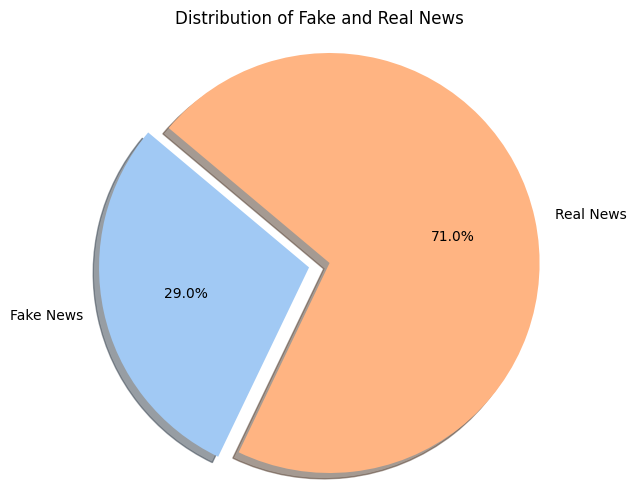

In [17]:
# Define palette
palette = sns.color_palette("pastel")

# Data
labels = ['Fake News', 'Real News']
sizes = [num_fake_news, num_real_news]
explode = (0.1, 0)  # explode 1st slice (i.e., 'Fake News')

# Plot
plt.figure(figsize=(6, 6))
plt.pie(sizes, explode=explode, labels=labels, colors=palette, autopct='%1.1f%%', shadow=True, startangle=140)
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.title('Distribution of Fake and Real News')
plt.show()

As we have already seen, the number of real news is extremely prevailing in our dataset, so we need to handle the imbalance between real and fake news classes.

In [18]:
X_train_tfidf_resampled, y_train_tfidf_resampled = oversampler.fit_resample(X_train_tfidf, y_train)
X_train_count_resampled, y_train_count_resampled = oversampler.fit_resample(X_train_count, y_train)

Now, we will apply all of the above mentioned steps to our validation and test datasets, as well.

# VALIDATION DATA

### Clean

In [19]:
val_data['clean_text'] = val_data['text'].apply(preprocess_text)
y_val = val_data['label']

### Tf-Idf Vectorzier

In [20]:
X_val_tfidf = tfidf_vectorizer.transform(val_data['clean_text'])

### Count Vectorizer

In [21]:
X_val_count = count_vectorizer.transform(val_data['clean_text'])

### Handling Class Imbalance

In [22]:
X_val_tfidf_resampled, y_val_tfidf_resampled = oversampler.fit_resample(X_val_tfidf, y_val)
X_val_count_resampled, y_val_count_resampled = oversampler.fit_resample(X_val_count, y_val)

# TEST DATA

### Clean

In [23]:
test_data['clean_text'] = test_data['text'].apply(preprocess_text)

### Tf-Idf Vectorzier

In [24]:
X_test_tfidf = tfidf_vectorizer.transform(test_data['clean_text'])
y_test = test_data['label']

### Count Vectorizer

In [25]:
X_test_count = count_vectorizer.transform(test_data['clean_text'])

### Handle Class Imbalance

In [26]:
X_test_tfidf_resampled, y_test_tfidf_resampled = oversampler.fit_resample(X_test_tfidf, y_test)
X_test_count_resampled, y_test_count_resampled = oversampler.fit_resample(X_test_count, y_test)

# MULTINOMIAL NAIVE BAYES MODEL USING PACKAGE

We have decided to employ the Multinomial Naive Bayes (MNB) model for modeling fake news detection.

The Multinomial Naive Bayes (MNB) model is a suitable choice for fake news detecasks for several reasons:

1. **Textual Data**: The dataset consists of text data, where each news article is repretokens. Multinomial Naive Bayes is a popular choice for text classification tasks due to its simplicity and effectiveness in handling textual data.

2. **Multiclass Classification**: Fake news detection involves multiclass classification, where news articles are categorized into two classes: fake or real. Multinomial Naive Bayes is well-suited for multiclass classification problems and can efficiently handle multiple classes.

3. **Assumption of Feature Independence**: Multinomial Naive Bayes assumes that features (words or tokens) are conditionally independent given the class label. While this assumption may not hold true in all cases, it often works well in practice, especially for text classification which is our case. While individual words or phrases in news articles may be related in meaning, the occurrence of one word or phrase is often independent of the occurrence of others, especially when conditioned on the article's class (fake or real). 


We begin by making use of the already implemented MultinomislNB class from the sklearn package to compare its performance with that of our implementation.

### Hyperparameter Tuning for Multinomial Naive Bayes Model

Hyperparameter tuning is a crucial step in optimizing the performance of machine learning models. In this case, we are tuning the hyperparameter `alpha` for the Multinomial Naive Bayes (MNB) model.

#### Why Hyperparameter Tuning?

The `alpha` hyperparameter is a smoothing parameter used in Multinomial Naive Bayes to handle cases where certain words are absent in the training data but appear in the test data. Tuning this hyperparameter allows us to find the optimal value that improves the generalization ability of the model.

#### How Hyperparameter Tuning is Done:

1. **Define Grid of Hyperparameters**: We define a grid of `alpha` values to search over. These values are chosen based on a range of possible values that are likely to yield good performance.

2. **Initialize Model**: We initialize a Multinomial Naive Bayes model without specifying any hyperparameters.

3. **Grid Search with Cross-Validation**: We perform a grid search with cross-validation (5-fold) using the defined grid of hyperparameters. Each combination of hyperparameters is evaluated using cross-validation to estimate the model's performance.

4. **Select Best Hyperparameter**: We select the best performing hyperparameter based on a chosen evaluation metric (in this case, accuracy). The best hyperparameter is the one that maximizes the model's performance on the validation set.

5. **Use Best Hyperparameter**: Finally, we use the best hyperparameter obtained from the grid search to train the final model on the entire training dataset.


The below provided code snippet demonstrates the process of hyperparameter tuning for the Multinomial Naive Bayes model using a grid search with cross-validation. After identifying the best `alpha` value, we use it to train the final model, ensuring optimal performance for fake news detection.

In [27]:
# Define the grid of hyperparameters to search
param_grid = {'alpha': [0.01, 0.05, 0.1, 0.2, 0.3, 0.5, 0.7, 1.0, 1.2, 1.5, 2.0, 5.0, 10.0, 100.0]}  # Define alpha values to search

# Initialize the Multinomial Naive Bayes model
mnb_hyperpar = MultinomialNB()

# Perform grid search using cross-validation
grid_search = GridSearchCV(mnb_hyperpar, param_grid, cv=5, scoring='accuracy')

# Fit the grid search to find the best hyperparameters
grid_search.fit(X_train_count, y_train)

GridSearchCV(cv=5, estimator=MultinomialNB(),
             param_grid={'alpha': [0.01, 0.05, 0.1, 0.2, 0.3, 0.5, 0.7, 1.0,
                                   1.2, 1.5, 2.0, 5.0, 10.0, 100.0]},
             scoring='accuracy')

In [28]:
# Getting the best hyperparameter
best_alpha = grid_search.best_params_['alpha']
print('Best Regularization strength: ', best_alpha)

Best Regularization strength:  0.05


The code snippet provided below initializes and fits the Multinomial Naive Bayes model using different feature representations (TF-IDF and Count) and datasets (original and resampled). It then evaluates the model's performance on validation and test sets, reporting accuracy scores for each configuration.

In [29]:
for i in [(X_train_tfidf, y_train, X_val_tfidf, 'Tf-Idf', X_test_tfidf),
          (X_train_tfidf_resampled, y_train_tfidf_resampled, X_val_tfidf, 'Tf-Idf resampled', X_test_tfidf),
          (X_train_count, y_train, X_val_count, 'Count', X_test_count),
          (X_train_count_resampled, y_train_count_resampled, X_val_count, 'Count resampled', X_test_count)]:

               
                # Initialize and Fit the Model Using Train Set
                mnb = MultinomialNB(alpha=best_alpha)  
                mnb.fit(i[0], i[1])
            
                # Predict labels for valid data
                y_pred_mnb = mnb.predict(i[2])
                
                # Check the Accuracy on Valid Set
                accuracy_mnb = accuracy_score(y_val, y_pred_mnb) 
                print(f"Accuracy on valid set using MultinomialNB {i[3]}:", accuracy_mnb)
            
                # Predict labels for test data
                predicted_labels = mnb.predict(i[4])  
                
                # Finalize on Test Set
                accuracy = accuracy_score(y_test, predicted_labels)
                print("Accuracy on the test data:", accuracy, '\n')


Accuracy on valid set using MultinomialNB Tf-Idf: 0.9394088669950739
Accuracy on the test data: 0.9405201714201271 

Accuracy on valid set using MultinomialNB Tf-Idf resampled: 0.9395073891625616
Accuracy on the test data: 0.9409634993350081 

Accuracy on valid set using MultinomialNB Count: 0.9335467980295566
Accuracy on the test data: 0.9335377567607507 

Accuracy on valid set using MultinomialNB Count resampled: 0.9341133004926109
Accuracy on the test data: 0.9348677405053938 



# MULTINOMIAL NAIVE BAYES MODEL IMPLEMENTATION

The Multinomial Naive Bayes classifier is designed based on the principles of the Naive Bayes algorithm, which is a probabilistic model that applies Bayes' theorem with strong (naive) independence assumptions between the features. The "Multinomial" part of the classifier's name refers to the probability distribution it assumes for the features (class conditional). So, using the Naive Bayes algorithm, we get the posterior ( $ Posterior ∝ Class Conditional × Class Prior $ ). More specifically, we get the logarithm of the posterior. When working with probabilities, especially when dealing with small probabilities or multiplying many probabilities together, the values can become very small, leading to numerical underflow. Taking logarithms helps prevent numerical instability by transforming products of probabilities into sums of logarithms  and thenassigning the text to the class with a  higher probability.

1. **Class Prior Calculation:**
   $$ P(Y = y_i) = \frac{{N_{y_i} + \alpha}}{{N + \alpha \times K}} $$
   *Where:*
 
   - $ N $ is the total number of samples.
   - $ N_{y_i} $ is the number of samples with class $ y_i $.
   - $ K $ is the number of classes.
   - $ \alpha $ is the smoothing parameter.


2. **Feature Probability Calculation:**
   $$ P(X_j = x_{ji} | Y = y_i) = \frac{{N_{y_i, x_{ji}} + \alpha}}{{N_{y_i} + \alpha \times D}} $$
   *Where:*
   
   - $ N_{y_i, x_{ji}} $ is the number of times feature $ x_{ji} $ appears in samples of class $ y_i $.
   - $ D $ is the total number of features (words or tokens)
  

3. **Log Probability Calculation:**
      $$ \log(P(Y = y_i | X)) = \log(P(Y = y_i)) + \sum_{j=1}^{D} X_j \times \log(P(X_j | Y = y_i)) $$



4. **Prediction:**
   $$ \hat{y} = \arg\max_{y_i} \log(P(Y = y_i | X)) $$
   *Where:*
   - $ X $ is the input feature vector.
   - $ Y $ is the set of possible classes.
   - $ X_j $ is the $ j $-th feature in the input vector $ X $.
   - $ x_{ji} $ represents the $ i $-th value of feature $ j $.
   - $ \hat{y} $ is the predicted class label.

In [30]:
class MultinomialNaiveBayes:
    def __init__(self, alpha=1.0):
        """
        Multinomial Naive Bayes classifier for text classification tasks.
    
        Parameters:
        -----------
        alpha : float, default=1.0
            Smoothing parameter for Laplace smoothing.
    
        Attributes:
        -----------
        alpha : float
            Smoothing parameter for Laplace smoothing.
        class_prior : array-like
            Prior probabilities of each class.
        feature_prob : array-like
            Probability of each feature given each class.
        classes : array-like
            Unique classes in the training data.
        """

        
        self.alpha = alpha  # Smoothing parameter
        self.class_prior = None
        self.feature_prob = None
        self.classes = None

    def fit(self, X, y):
        """
        Fit the Multinomial Naive Bayes classifier to the training data.

        Args:
        X (array-like, shape (n_samples, n_features)): Training samples.
        y (array-like, shape (n_samples,)): Target values.

        Returns:
        None
        """
        
        n_samples, n_features = X.shape
        self.classes = np.unique(y)
        n_classes = len(self.classes)

        # Initialize class prior and feature probabilities arrays
        self.class_prior = np.zeros(n_classes)
        self.feature_prob = np.zeros((n_classes, n_features))

        # Compute class prior and feature probabilities
        for i, c in enumerate(self.classes):
            X_c = X[y == c]
            class_prior_smoothed = (X_c.shape[0] + self.alpha) / (n_samples + self.alpha * n_classes)
            self.class_prior[i] = class_prior_smoothed
            total_word_counts = np.sum(X_c)
            self.feature_prob[i, :] = (np.sum(X_c, axis=0) + self.alpha) / (total_word_counts + self.alpha * n_features)

    def predict(self, X):
        """
        Predict the class labels for the input samples.

        Args:
        X (array-like, shape (n_samples, n_features)): Input samples.

        Returns:
        array, shape (n_samples,): Predicted class labels.
        """
        
        n_samples = X.shape[0]
        scores = np.zeros((n_samples, len(self.classes)))

        # Compute log probabilities for each class
        for i, c in enumerate(self.classes):
            class_prior = self.class_prior[i]
            feature_prob = self.feature_prob[i, :]
            scores[:, i] = np.log(class_prior) + X.dot(np.log(feature_prob))

        # Predict the class with the highest score for each sample
        return self.classes[np.argmax(scores, axis=1)]


The code snippet provided below initializes and fits the Multinomial Naive Bayes model (implemented one) using different feature representations (TF-IDF and Count) and datasets (original and resampled). It then evaluates the model's performance on validation and test sets, reporting accuracy scores for each configuration.

In [31]:
for i in [(X_train_tfidf, y_train, X_val_tfidf, 'Tf-Idf', X_test_tfidf),
          (X_train_tfidf_resampled, y_train_tfidf_resampled, X_val_tfidf, 'Tf-Idf resampled', X_test_tfidf),
          (X_train_count, y_train, X_val_count, 'Count', X_test_count),
          (X_train_count_resampled, y_train_count_resampled, X_val_count, 'Count resampled', X_test_count)]:
               
                # Initialize and Fit the Model Using Train Set
                mnb = MultinomialNaiveBayes(alpha=best_alpha)  
                mnb.fit(i[0], i[1])
            
                # Predict labels for valid data
                y_pred_mnb = mnb.predict(i[2])
                
                # Check the Accuracy on Valid Set
                accuracy_mnb = accuracy_score(y_val, y_pred_mnb) 
                print(f"Accuracy on valid set using MultinomialNB {i[3]}:", accuracy_mnb)
            
                # Predict labels for test data
                predicted_labels = mnb.predict(i[4])  
                
                # Finalize on Test Set
                accuracy = accuracy_score(y_test, predicted_labels)
                print("Accuracy on the test data:", accuracy, '\n')


Accuracy on valid set using MultinomialNB Tf-Idf: 0.9394088669950739
Accuracy on the test data: 0.9405201714201271 

Accuracy on valid set using MultinomialNB Tf-Idf resampled: 0.9395073891625616
Accuracy on the test data: 0.9409634993350081 

Accuracy on valid set using MultinomialNB Count: 0.9335467980295566
Accuracy on the test data: 0.9335377567607507 

Accuracy on valid set using MultinomialNB Count resampled: 0.9341133004926109
Accuracy on the test data: 0.9348677405053938 



# GAUSSIAN NAIVE BAYES MODEL USING PACKAGE

We have also decided to explore the Gaussian Naive Bayes (GNB) model for modeling fake news detection, alongside the Multinomial Naive Bayes (MNB) model.

The Gaussian Naive Bayes (GNB) model is another suitable choice for fake news detection, especially when dealing with continuous features or data that can be reasonably assumed to follow a Gaussian (normal) distribution. While MNB is commonly used for text classification tasks, GNB can be effective when dealing with numeric features (which we get by different types of numeric representations of words already explained above).

Similar to MNB, GNB also offers several advantages:

1. **Multiclass Classification**: GNB can handle multiclass classification problems where news articles need to be categorized into two classes: fake or real. It is well-suited for scenarios where the features can be assumed to follow a Gaussian distribution. In our case we make that assumption since the aggregated counts of words across multiple documents(rows of data) may tend to approximate a Gaussian distribution, especially when considering a large vocabulary. Additionally, when using techniques like TF-IDF, the resulting feature space may exhibit more Gaussian-like behavior due to normalization and weighting.

2. **Assumption of Feature Independence**: Like MNB, GNB also assumes that features are conditionally independent given the class label. This simplifies the modeling process and makes GNB computationally efficient, especially for our large datasets. Each news article typically focuses on a specific topic or event, and the choice of words or phrases within the article is influenced by its subject matter. However, the independence assumption holds that the presence or absence of specific terms within an article is determined primarily by whether the article is fake or real, rather than by interactions between the terms themselves. 

3. **Robustness to Noisy Data**: GNB is known for its robustness to noisy data and its ability to handle missing values. It can perform well even when some assumptions of the underlying data distribution are violated.

We will proceed to implement the Gaussian Naive Bayes model using the `GaussianNB` class from the `sklearn` package and evaluate its performance alongside Custom GNB the (Custom) MNB model.


### Hyperparameter Tuning for Gaussian Naive Bayes Model
. In the case of Gaussian Naive Bayes (GNB), one of the critical hyperparameters to tune is `var_smoothing`.

#### Why Hyperparameter Tuning?

The `var_smoothing` hyperparameter is a smoothing parameter used to stabilize the computation of probabilities, especially when dealing with features with zero variance. By tuning this hyperparameter, we aim to find an optimal value that enhances the model's generalization capability.

#### How Hyperparameter Tuning is Done:

1. **Define Grid of Hyperparameters**: We define a grid of `var_smoothing` values to search over. These values are chosen based on a range of possible values that are likely to yield good performance.

2. **Initialize Model**: We initialize a Gaussian Naive Bayes model without specifying any hyperparameters.

3. **Grid Search with Cross-Validation**: We perform a grid search with cross-validation (5-fold) using the defined grid of hyperparameters. Each combination of hyperparameters is evaluated using cross-validation to estimate the model's performance.

4. **Select Best Hyperparameter**: We select the best-performing hyperparameter based on a chosen evaluation metric (in this case, accuracy). The best hyperparameter is the one that maximizes the model's performance on the validation set.

5. **Use Best Hyperparameter**: Finally, we use the best hyperparameter obtained from the grid search to train the final model on the entire training dataset.

The provided code snippet below demonstrates the process of hyperparameter tuning for the Gaussian Naive Bayes model using a grid search with cross-validation. After identifying the best `var_smoothing` value, we use it to train the final model, ensuring optimal performance for ake news detection.


In [32]:
# Define the grid of hyperparameters to search
param_grid = {'var_smoothing': [0.01, 0.05, 0.1, 0.2, 0.3, 0.5, 0.7, 1.0, 1.2, 1.5, 2.0, 5.0, 10.0, 100.0]}  # Define alpha values to search

# Initialize the Gaussian Naive Bayes model
gnb_hyperpar = GaussianNB()

# Perform grid search using cross-validation
grid_search = GridSearchCV(gnb_hyperpar, param_grid, cv=5, scoring='accuracy')

# Fit the grid search to find the best hyperparameters
svd.fit(X_train_tfidf)
grid_search.fit(svd.transform(X_train_tfidf), y_train)

GridSearchCV(cv=5, estimator=GaussianNB(),
             param_grid={'var_smoothing': [0.01, 0.05, 0.1, 0.2, 0.3, 0.5, 0.7,
                                           1.0, 1.2, 1.5, 2.0, 5.0, 10.0,
                                           100.0]},
             scoring='accuracy')

In [33]:
# Getting the best hyperparameter
best_var_smoothing = grid_search.best_params_['var_smoothing']
print('Best Regularization strength: ', best_var_smoothing)

Best Regularization strength:  0.05


The code snippet provided below initializes and fits the Gaussian Naive Bayes model using different feature representations (TF-IDF and Count) and datasets (original and resampled) in **a reduced feature space**. It then evaluates the model's performance on validation and test sets, reporting accuracy scores for each configuration.

In [34]:
for i in [(X_train_tfidf, y_train, X_val_tfidf, 'Tf-Idf', X_test_tfidf),
          (X_train_tfidf_resampled, y_train_tfidf_resampled, X_val_tfidf, 'Tf-Idf resampled', X_test_tfidf),
          (X_train_count, y_train, X_val_count, 'Count', X_test_count),
          (X_train_count_resampled, y_train_count_resampled, X_val_count, 'Count resampled', X_test_count)]:

    
                # Initialize and Fit the Model Using Train Set
                gnb = GaussianNB(var_smoothing=best_var_smoothing) 
                gnb.fit(svd.transform(i[0]), i[1])
            
                # Predict labels for valid data
                y_pred_gnb = gnb.predict(svd.transform(i[2]))
                
                # Check the Accuracy on Valid Set
                accuracy_gnb = accuracy_score(y_val, y_pred_gnb) 
                print(f"Accuracy on valid set using GaussianNB {i[3]}:", accuracy_gnb)
            
                # Predict labels for test data
                predicted_labels = gnb.predict(svd.transform(i[4])) 
                
                # Finalize on Test Set
                accuracy = accuracy_score(y_test, predicted_labels)
                print("Accuracy on the test data:", accuracy, '\n')


Accuracy on valid set using GaussianNB Tf-Idf: 0.8343596059113301
Accuracy on the test data: 0.8371139352741245 

Accuracy on valid set using GaussianNB Tf-Idf resampled: 0.8346305418719212
Accuracy on the test data: 0.8364119994088961 

Accuracy on valid set using GaussianNB Count: 0.8026600985221675
Accuracy on the test data: 0.8039382296438599 

Accuracy on valid set using GaussianNB Count resampled: 0.8053448275862068
Accuracy on the test data: 0.8068198610905867 



# GAUSSIAN NAIVE BAYES MODEL IMPLEMENTATION

The Gaussian Naive Bayes (GNB) classifier is designed based on the principles of the Naive Bayes algorithm, similar to the Multinomial Naive Bayes model. However, instead of assuming a multinomial distribution for the features, GNB assumes a Gaussian distribution. The Gaussian Naive Bayes classifier calculates the log-likelihood of the data given each class using the Gaussian probability density function. It then combines the log-likelihood with the log prior probability to compute the log posterior probability. Finally, it assigns the class with the highest log probability as the predicted class label for each example.

.

1. **Class Prior Calculation:**
   $$ P(Y = y_i) = \frac{{N_{y_i} + \alpha}}{{N + \alpha \times K}} $$
   *Where:*
   - $ N $ is the total number of samples.
   - $ N_{y_i} $ is the number of samples with class $ y_i $.
   - $ K $ is the number of classes.
   - $ \alpha $ is the smoothing pad class label for each example.


2. **Feature Probability Calculation:**
   $$ P(X_j = x_{ji} | Y = y_i) = \frac{1}{{\sqrt{2\pi}\sigma_{y_i,j}}} \exp\left(-\frac{(x_{ji} - \mu_{y_i,j})^2}{2\sigma_{y_i,j}^2}\right) $$
   *Where:*
   - $ \mu_{y_i,j} $ is the mean of feature $ j $ in samples of class $ y_i $.
   - $ \sigma_{y_i,j} $ is the standard deviation of feature $ j $ in samples of class $ y_i $.



3. **Log Probability Calculation:**
   $$ \log(P(Y = y_i | X)) = \log(P(Y = y_i)) + \sum_{j=1}^{D} \log(P(X_j = x_{ji} | Y = y_i)) $$
   *Where:*
   - $ D $ is the total number of features.
   - $ X_j $ is the $ j $-th feature in the input vector $ X $.
   - $ x_{ji} $ represents the $ i $-th value of feature $ j $.



4. **Prediction:**
   $$ \hat{y} = \arg\max_{y_i} \log(P(Y = y_i | X)) $$
   *Where:*
   - $ X $ is the input feature vector.
   - $ Y $ is the set of possible classes.
   - $ \hat{y} $ is the predicted class label.



In [35]:
class GaussianNaiveBayes:
    """
    Gaussian Naive Bayes classifier for classification tasks assuming Gaussian (normal) distribution for features.

    Parameters:
    -----------
    alpha : float, default=1.0
        Smoothing parameter for Laplace smoothing to handle zero probabilities.
    
    Attributes:
    -----------
    classes : array-like
        Unique classes in the training data.
    class_prior : array-like
        Prior probabilities of each class.
    mean : dict
        Mean of each feature for each class.
    std : dict
        Standard deviation of each feature for each class.
    alpha : float
        Smoothing parameter for Laplace smoothing.
    """

    
    def __init__(self, alpha=1.0):
        """
        Initialize Gaussian Naive Bayes classifier.

        Parameters:
        -----------
        alpha : float, default=1.0
            Smoothing parameter for Laplace smoothing to handle zero probabilities.
        """
        
        self.classes = None
        self.class_prior = None
        self.mean = None
        self.std = None
        self.alpha = alpha
    
    def fit(self, X_train, y_train):
        """
        Fit the Gaussian Naive Bayes classifier to the training data.

        Parameters:
        -----------
        X_train : array-like of shape (n_samples, n_features)
            Training samples.
        y_train : array-like of shape (n_samples,)
            Target values.

        Returns:
        --------
        self : object
            Fitted GaussianNaiveBayes object.
        """
        
        # Calculate class priors
        self.classes, counts = np.unique(y_train, return_counts=True)
        self.class_prior = (counts + self.alpha) / (len(y_train) + len(self.classes) * self.alpha)
        
        # Initialize dictionaries to store mean and standard deviation for each class and feature
        self.mean = {}
        self.std = {}
        
        # Calculate mean and standard deviation for each feature in each class
        for cls in self.classes:
            cls_data = X_train[y_train == cls]
            self.mean[cls] = np.mean(cls_data, axis=0)
            self.std[cls] = np.std(cls_data, axis=0)        
    
    def predict(self, X_test):
        """
        Predict class labels for test data.

        Parameters:
        -----------
        X_test : array-like of shape (n_samples, n_features)
            Test samples.

        Returns:
        --------
        array-like of shape (n_samples,)
            Predicted class labels.
        """
        
        # Initialize array to store predicted class probabilities for each example
        class_probs = np.zeros((X_test.shape[0], len(self.classes)))
        
        # Calculate log-likelihood for each class
        for i, cls in enumerate(self.classes):
            # Compute log-likelihood using Gaussian probability density function
            log_likelihood = -0.5 * np.sum(((X_test - self.mean[cls]) / self.std[cls]) ** 2 + np.log(2 * np.pi * self.std[cls] ** 2), axis=1)
            
            # Add log prior probability
            log_posterior = log_likelihood + np.log(self.class_prior[i])
            class_probs[:, i] = log_posterior
        
        # Assign class with highest log probability
        predicted_classes = np.argmax(class_probs, axis=1)
        return self.classes[predicted_classes]


The code snippet provided below initializes and fits the Gaussian Naive Bayes model using different feature representations (TF-IDF and Count) and datasets (original and resampled) in **a reduced feature space**. It then evaluates the model's performance on validation and test sets, reporting accuracy scores for each configuration.

In [36]:
for i in [(X_train_tfidf, y_train, X_val_tfidf, 'Tf-Idf', X_test_tfidf),
          (X_train_tfidf_resampled, y_train_tfidf_resampled, X_val_tfidf, 'Tf-Idf resampled', X_test_tfidf),
          (X_train_count, y_train, X_val_count, 'Count', X_test_count),
          (X_train_count_resampled, y_train_count_resampled, X_val_count, 'Count resampled', X_test_count)]:

    
                # Initialize and Fit the Model Using Train Set
                gnb = GaussianNaiveBayes(alpha=best_var_smoothing) 
                gnb.fit(svd.transform(i[0]), i[1])
            
                # Predict labels for valid data
                y_pred_gnb = gnb.predict(svd.transform(i[2]))
                
                # Check the Accuracy on Valid Set
                accuracy_gnb = accuracy_score(y_val, y_pred_gnb) 
                print(f"Accuracy on valid set using Custom GaussianNB {i[3]}:", accuracy_gnb)
            
                # Predict labels for test data
                predicted_labels = gnb.predict(svd.transform(i[4])) 
                
                # Finalize on Test Set
                accuracy = accuracy_score(y_test, predicted_labels)
                print("Accuracy on the test data:", accuracy, '\n')


Accuracy on valid set using Custom GaussianNB Tf-Idf: 0.8221428571428572
Accuracy on the test data: 0.8243313137283877 

Accuracy on valid set using Custom GaussianNB Tf-Idf resampled: 0.8172660098522168
Accuracy on the test data: 0.8199719225653909 

Accuracy on valid set using Custom GaussianNB Count: 0.7656650246305419
Accuracy on the test data: 0.7696542042263927 

Accuracy on valid set using Custom GaussianNB Count resampled: 0.7560344827586207
Accuracy on the test data: 0.7586448943401802 



In [ ]:
# Write test_data to CSV
test_data.to_csv("test_data_cleaned.csv", index=False)

# Write val_data to CSV
val_data.to_csv("val_data_cleaned.csv", index=False)

# Write train_data to CSV
train_data.to_csv("train_data_cleaned.csv", index=False)